In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pyaurorax
import cartopy

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Download and Read Data

In [3]:
# download a minute of RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
start_dt = datetime.datetime(2023, 2, 24, 7, 5)
end_dt = start_dt
site_uid_list = ['yknf', 'gill', 'rabb', 'luck', 'atha']
data_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

In [4]:
# Read in the data site-by-site, as we need this separation for mosaicing
data_list = []
for site_uid, download_obj in data_download_objs.items():
    print(download_obj)
    data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

FileDownloadResult(filenames=[PosixPath('/home/josh/pyaurorax_data/TREX_RGB_RAW_NOMINAL/2023/02/24/yknf_rgb-08/ut07/20230224_0705_yknf_rgb-08_full.h5')], count=1, total_bytes=0, output_root_path='/home/josh/pyaurorax_data/TREX_RGB_RAW_NOMINAL', dataset=Dataset(name=TREX_RGB_RAW_NOMINAL, short_description='TREx RGB All Sky Imagers 3-sec raw data', provider='UCalgary', level='L0', doi_details='https://commons.datacite.org/doi.org/10.11575/4p8e-1k65', ...))
FileDownloadResult(filenames=[PosixPath('/home/josh/pyaurorax_data/TREX_RGB_RAW_NOMINAL/2023/02/24/gill_rgb-04/ut07/20230224_0705_gill_rgb-04_full.h5')], count=1, total_bytes=0, output_root_path='/home/josh/pyaurorax_data/TREX_RGB_RAW_NOMINAL', dataset=Dataset(name=TREX_RGB_RAW_NOMINAL, short_description='TREx RGB All Sky Imagers 3-sec raw data', provider='UCalgary', level='L0', doi_details='https://commons.datacite.org/doi.org/10.11575/4p8e-1k65', ...))
FileDownloadResult(filenames=[PosixPath('/home/josh/pyaurorax_data/TREX_RGB_RAW_NO

In [5]:
# Get list of all skymaps in previous two years up to date of interest for each site
skymap_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(
        "TREX_RGB_SKYMAP_IDLSAV",
        start_dt.replace(year=start_dt.year - 2),
        start_dt,
        site_uid=site_uid,
    )
    skymap_download_objs[site_uid] = download_obj

# Read and store the last list index skymap for each site, as that is most recent to the date of interest
skymaps = []
for site_uid, download_obj in skymap_download_objs.items():

    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
    skymaps.append(skymap.data[0])

skymaps

[Skymap(project_uid=rgb, site_uid=yknf, imager_uid=rgb-08, site_map_latitude=62.519848, site_map_longitude=245.686966, ...),
 Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=rgb, site_uid=atha, imager_uid=rgb-07, site_map_latitude=54.602631, site_map_longitude=246.355728, ...)]

## **Build ASI mosaic**

First, we'll create our mosaic using the ASI data. Later on, we'll overplot the satellite location information.

In [6]:
# prepare the skymap data
prepped_skymap = at.mosaic.prep_skymaps(skymaps, 110, n_parallel=2)

# prepare the image data
prepped_images = at.mosaic.prep_images(data_list)

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

In [7]:
# define the intensity scales for each site
scale = {
    "yknf": [10, 90],
    "gill": [10, 90],
    "rabb": [10, 90],
    "luck": [10, 90],
    "atha": [10, 90],
}

# Set timestamp to actually create mosaic frame for
mosaic_dt = datetime.datetime(2023, 2, 24, 7, 5, 0)

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymap, mosaic_dt, projection_obj, image_intensity_scales=scale)

# Add geographic gridlines using many lines of constant lat and lon. These will go behind the image data
lat_locs = np.arange(0, 90, 10)
lon_locs = np.arange(-180, 0, 20)

# Add gridlines
mosaic.add_geo_contours(constant_lats=lat_locs, constant_lons=lon_locs, linestyle='--', color='black')

## **Overplot Satellite Location Data**

Now that we have our mosaic created using the ASI data, we need to retrieve some satellite location data. We will utilize the AuroraX search engine for this, searching for 'ephemeris' data.

More information about performing AuroraX ephemeris and conjunction searches can be found [here](https://docs.aurorax.space/code/basic_usage/overview/).

In [8]:
# Set values of interest - let's grab 30 minutes of data from Swarm A
start = datetime.datetime(2023, 2, 24, 6, 50, 0)
end = datetime.datetime(2023, 2, 24, 7, 20, 0)
programs = ["swarm"]
platforms = ["swarma"]
instrument_types = ["footprint"]

# Perform search
s = aurorax.search.ephemeris.search(start, end, programs=programs, platforms=platforms, instrument_types=instrument_types, verbose=True)

# Organize data into a list of dicts
ephemeris_data = [e.__dict__ for e in s.data]

# Create lists of lats and lons for all timestamps
lats = []
lons = []
for i in range(len(ephemeris_data)):
    lats.append(ephemeris_data[i]['location_geo'].lat)
    lons.append(ephemeris_data[i]['location_geo'].lon)

# Add the footprint of Swarm A over 30 minutes
mosaic.add_geo_contours(lats=lats, lons=lons, linestyle='-', color='red', bring_to_front=True)

# Get exact location of satellite at time of mosaic
start = datetime.datetime(2023, 2, 24, 7, 5, 0)
end = datetime.datetime(2023, 2, 24, 7, 5, 0)
programs = ["swarm"]
platforms = ["swarma"]
instrument_types = ["footprint"]

s = aurorax.search.ephemeris.search(start, end, programs=programs, platforms=platforms, instrument_types=instrument_types, verbose=True)

# Organize data into a list of dicts
ephemeris_data = [e.__dict__ for e in s.data]

# Create lists of lats and lons for all timestamps
lats = []
lons = []
for i in range(len(ephemeris_data)):
    lats.append(ephemeris_data[i]['location_geo'].lat)
    lons.append(ephemeris_data[i]['location_geo'].lon)

[2024-12-06 20:00:31.787418] Search object created
[2024-12-06 20:00:31.825567] Request submitted
[2024-12-06 20:00:31.825598] Request ID: 266a901c-84e6-4d86-b4e1-4fc8dec13c96
[2024-12-06 20:00:31.825602] Request details available at: https://api.aurorax.space/api/v1/ephemeris/requests/266a901c-84e6-4d86-b4e1-4fc8dec13c96
[2024-12-06 20:00:31.825605] Waiting for data ...
[2024-12-06 20:00:33.344964] Checking for data ...
[2024-12-06 20:00:33.789459] Data is now available
[2024-12-06 20:00:33.789550] Retrieving data ...
[2024-12-06 20:00:33.876670] Retrieved 177.5 kB of data containing 31 records
[2024-12-06 20:00:33.882316] Search object created
[2024-12-06 20:00:33.901262] Request submitted
[2024-12-06 20:00:33.901282] Request ID: c1f19184-0480-4b69-8dc3-66acea31ea3a
[2024-12-06 20:00:33.901286] Request details available at: https://api.aurorax.space/api/v1/ephemeris/requests/c1f19184-0480-4b69-8dc3-66acea31ea3a
[2024-12-06 20:00:33.901289] Waiting for data ...
[2024-12-06 20:00:35.33

In [9]:
# Add the location of SWARM A at the exact time of this mosaic
mosaic.add_geo_contours(lats=lats, lons=lons, color='red', bring_to_front=True, marker="o")

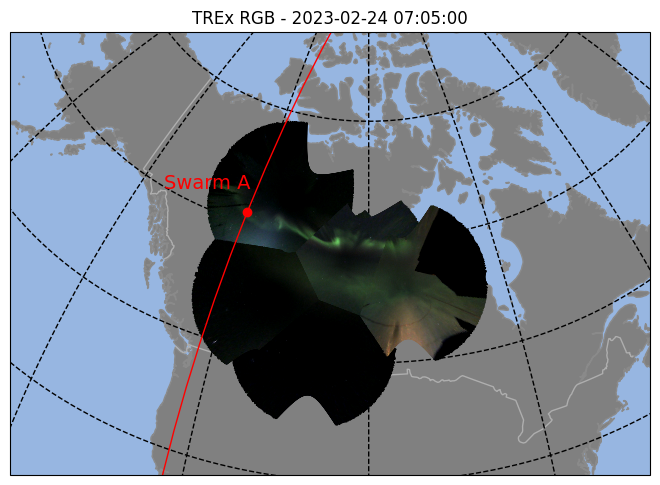

In [10]:
# Obtain mosaic plot so we can do some custom things to it
map_extent = [-140, -70, 35, 75]
fig, geo_axes = mosaic.plot(map_extent, title="TREx RGB - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")), returnfig=True)

# Plot the mosaic and add some of our own text
plt.figure(fig.number)
geo_axes.text(lons[0]-15,lats[0]-1,"Swarm A", color="red", transform=cartopy.crs.PlateCarree(), fontsize=14)  # Add label for satellite
plt.show()